# **Reinforcement Learning Project - BlackJack**


### In this project, we will try to identify the most effective game strategy for Blackjack through reinforcement learning. You will have the opportunity to investigate the fundamentals of Reinforcement Learning and explore various approaches.

## Objectives

Key aspects of this project

*   OpenAI Gym Environment Selection
*   Reinforcement Learning Concept Explanation
*   Blackjack Environment Training and Testing
*   Environment Setup
*   Learning Techniques
*   Experiment Logging
*   Comparisons and Analyses

----


## __Table of Contents__
<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Setup">Import Libraries and Setup</a>
    <li><a href="#Setup">Blackjack Environment</a>
    <li><a href="#Setup">Models</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Random</a></li>
            <li><a href="#Importing-Required-Libraries">Monte Carlo Method</a></li>
            <li><a href="#Defining-Helper-Functions">QLearning</a></li>
             <li><a href="#Defining-Helper-Functions">Sarsa (Temporal Difference control)</a></li>
        </ol>
    </li>
</ol>


## 1. Objectives


### Define the objectives

## 2. Import Libraries and Setup 

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [1]:
# !pip install gym==0.22.0 pygame

import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..') 
from tqdm import tqdm
from collections import defaultdict
from matplotlib.patches import Patch

from src.features.blackjackutility import game_result, average_wins, games_with_policy
from src.visualization.visualize import plot_value_function, plot_policy_blackjack
from src.models.MonteCarlo import monte_carlo_ES
from src.models.QLearning import QLearning, games_with_policy_QLearning, average_wins_QLearning
from src.models.QLearning_class import BlackjackAgent
from src.models.Sarsa_class import SarsaAgent

## 3. Blackjack Environment

We create an openAI gym blackjack enviroment by calling gym method through the use of Make function.


In [2]:
environment = gym.make("Blackjack-v1", sab = True)

Now, it's time to explore the observation space in our environment. The observation space represents the set of all conceivable states, and we can access this space using the observation_space method

In [3]:
print(environment.observation_space)
print(environment.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


This can be described as:

States -> Tuple(Discrete(32), Discrete(11), Discrete(2)) where:
* The player's card sum can range from the lowest (1) to the highest (11, 10, 11), resulting in 32 possible states.
* The dealer's face-up card can take values between 1 and 11.
* The 'usable Ace' space can be either True or False, equating to 2 possible states.

    Hence, there are a total of 704 possible states, computed as: $32 \times 11 \times 2 = 704$. 

Actions -> [0,1]
* Either stand or hit: [0,1] i.e 0 for stand , 1 for hit


In [4]:
state = environment.reset()
print("s_{} = {}".format(0, environment.observation_space.sample())) 

s_0 = (6, 5, 1)


Let's see more possible states:


In [5]:
for i in range(15):
    print("s_{} = {}".format(i, environment.observation_space.sample()))

s_0 = (21, 2, 0)
s_1 = (22, 7, 0)
s_2 = (14, 4, 0)
s_3 = (30, 2, 0)
s_4 = (6, 4, 1)
s_5 = (5, 3, 1)
s_6 = (15, 4, 1)
s_7 = (15, 10, 1)
s_8 = (25, 5, 1)
s_9 = (29, 3, 1)
s_10 = (6, 0, 0)
s_11 = (18, 2, 0)
s_12 = (13, 4, 0)
s_13 = (20, 4, 1)
s_14 = (25, 9, 0)


In [6]:
for t in range(10):
    action=environment.action_space.sample()
    if action:
        print("Hit, A_{} = {}".format(t,action))
    else:
        print("Stay",action)

Hit, A_0 = 1
Hit, A_1 = 1
Stay 0
Stay 0
Stay 0
Hit, A_5 = 1
Hit, A_6 = 1
Stay 0
Hit, A_8 = 1
Hit, A_9 = 1


Let's also check the player and dealers cards by using `environment.player` and `environment.dealer` function 


In [7]:
print(environment.observation_space.sample())
print(environment.player)
print(environment.dealer)

(0, 8, 1)
[4, 10]
[5, 10]


We will introduce a bit more terminology, **Episode** is a set of  agent-environment interactions from initial to final state, i.e it's one game that agent the plays. In addition, our agents are operating in a discrete-time game. Each time-advancing decision is a **step** (e.x. taking some action from some state). It's easy to see that each Episode consists of a series of steps. 

Let's play through some episodes of the game, choosing random actions for each step: 


In [8]:
episodes = 2
sum_ = 0
result = 0
error = 0

#setting the seed for reproduceability

for episode in range(episodes):
    state = environment.reset()
    done = False
    print("_________________________________________")
    print("Episode {}".format(episode))
   

    print("State: {}".format(state))
    print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
    print("The Agent has the following cards: {}".format(environment.player))
    print('The Dealer has the following cards: {}'.format(environment.dealer))
    while not done:
    
        action = environment.action_space.sample()
       
        if action:
            print("Hit")
            
        else:
            print("Stand")

        state, reward, done, info = environment.step(action)

        print("State: {}".format(state))
        print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
        print("The Agent has the following cards: {}".format(environment.player))
        print('The Dealer has the following cards: {}'.format(environment.dealer))

    print("Done: {}".format(done))
    result = game_result(environment,state)
    sum_ += reward
sum_

_________________________________________
Episode 0
State: (14, 1, False)
The Agent's current sum: 14, The Dealer's one showing card: 1, Agent's usable ace: False
The Agent has the following cards: [7, 7]
The Dealer has the following cards: [1, 5]
Hit
State: (17, 1, False)
The Agent's current sum: 17, The Dealer's one showing card: 1, Agent's usable ace: False
The Agent has the following cards: [7, 7, 3]
The Dealer has the following cards: [1, 5]
Hit
State: (19, 1, False)
The Agent's current sum: 19, The Dealer's one showing card: 1, Agent's usable ace: False
The Agent has the following cards: [7, 7, 3, 2]
The Dealer has the following cards: [1, 5]
Stand
State: (19, 1, False)
The Agent's current sum: 19, The Dealer's one showing card: 1, Agent's usable ace: False
The Agent has the following cards: [7, 7, 3, 2]
The Dealer has the following cards: [1, 5, 4]
Done: True
state: (19, 1, False)
player has [7, 7, 3, 2]
the players current sum:19,dealer's one showing card:1, usable ace:False
de

-2.0

Run the code above a few more times and observe that our games are not really lucky. Try playing yourself, may be you can do better than a random action generator:


In [9]:
episodes = 10
sum_ = 0
result = 0
error = 0

#setting the seed for reproduceability

for episode in range(episodes):
    state = environment.reset()
    done = False
    print("_________________________________________")
    print("Episode {}".format(episode))
   

    print("State: {}".format(state))
    print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
    print("The Agent has the following cards: {}".format(environment.player))
    print('The Dealer has the following cards: {}'.format(environment.dealer))
    while not done:
    
        action = environment.action_space.sample()
       
        if action:
            print("Hit")
            
        else:
            print("Stand")

        state, reward, done, info = environment.step(action)

        print("State: {}".format(state))
        print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
        print("The Agent has the following cards: {}".format(environment.player))
        print('The Dealer has the following cards: {}'.format(environment.dealer))

    print("Done: {}".format(done))
    result = game_result(environment,state)
    sum_ += reward
sum_

_________________________________________
Episode 0
State: (19, 4, False)
The Agent's current sum: 19, The Dealer's one showing card: 4, Agent's usable ace: False
The Agent has the following cards: [9, 10]
The Dealer has the following cards: [4, 10]
Hit
State: (29, 4, False)
The Agent's current sum: 29, The Dealer's one showing card: 4, Agent's usable ace: False
The Agent has the following cards: [9, 10, 10]
The Dealer has the following cards: [4, 10]
Done: True
state: (29, 4, False)
player has [9, 10, 10]
the players current sum:29,dealer's one showing card:4, usable ace:False
dealer cards: [4, 10] and score: 14 your score i: 29 
Bust
_________________________________________
Episode 1
State: (15, 3, True)
The Agent's current sum: 15, The Dealer's one showing card: 3, Agent's usable ace: True
The Agent has the following cards: [4, 1]
The Dealer has the following cards: [3, 6]
Stand
State: (15, 3, True)
The Agent's current sum: 15, The Dealer's one showing card: 3, Agent's usable ace: 

-6.0

At first we will start by exploring what greedy policy is and does:


### Epsilon-Greedy Policy

If you remember, as was mentioned before, policy is just a function that defines which action our agent should take based on the current state. In our environment, a simple deterministic policy $\pi$ for the the state $(15,10,0)$ may look like: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.36.45%20AM.png" width="50%" alt="iris image">


You may ask why wouldn't we always use the best action, the action with the best estimated reward, what's the point of this epsilon constant. For it we will have to learn about 2 more concepts: 
 
* **Exploration** happens when the agent takes the random action to explore more opportunities, gather more information about possible actions and the environment.
* **Exploitation** happens when the agent makes the best decision given current information, it uses the best estimated action to maximize the reward. 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.51.11%20AM.png" width="50%" alt="iris image">

As demonstrated in the diagram above, **Epsilon** defines the trade-off between Exploration and Exploitation.  We need it because the best long-term strategy may involve short-term sacrifices and in most cases, agents must explore the environment and gather enough information to make the best overall decisions. It may save our agent from doing decisions that work instead of finding the best actions. 

Let's define a new python function that will follow the epsilon probability and return an action:


## 4. Models

### 4.1 Random

### 4.2 Monte Carlo Method

#### 4.2.1 Monte Carlo with First Starts
This concept is an important strategic decision that you have to make every time you build an episode based learning algorithm. Note that every episode, we update our Q function, based on states and actions that were visited, some state-action pairs can be visited more than one per episode. **Every-Visit MC** is Monte Carlo algorithm that averages returns for every time state-action pair is visited in an episode, where **First-visit MC** averages returns only for first time state-action pair is visited in an episode.


#### 4.2.2 Monte Carlo with Exploring-Starts
Note that in big and complicated environments not every (state,action) pair may be visited during the learning process. One possible solution to this problem may be adding **exploring-starts** method. In the beginning of each episode we are always starting in the initial state $S$, but with exploring-starts we will choose our starting state randomly. **Exploring-starts** is specifying that episodes start in a state–action pair, and that every pair has a nonzero probability of being selected as the start.

In [10]:
policy, V, Q, DELTA = monte_carlo_ES(environment, N_episodes = 200000, discount_factor = 1, epsilon = 0.1, first_visit = True, theta=0)  

Let's plot the delta value for each episode to see how the update rates are changing:


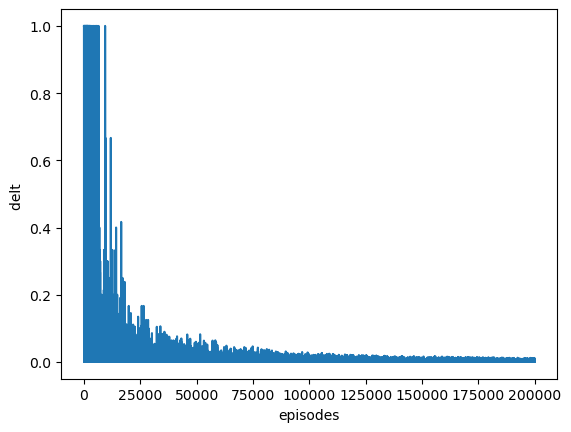

In [11]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

As you can see the delta parameter is generally decreasing, which makes sense since our model comes closer and closer to the optimal values for the value function. Speaking of which, let's see the map of expected returns based on what player has and what the dealer has. 


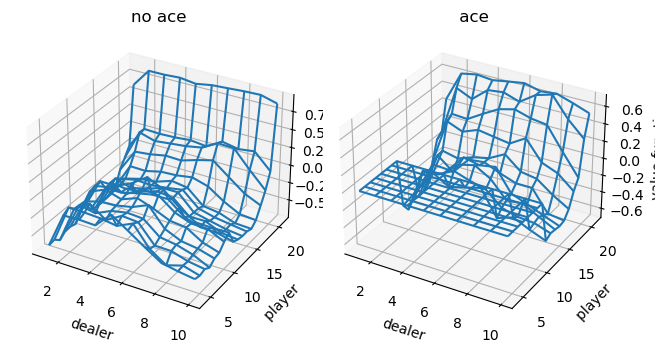

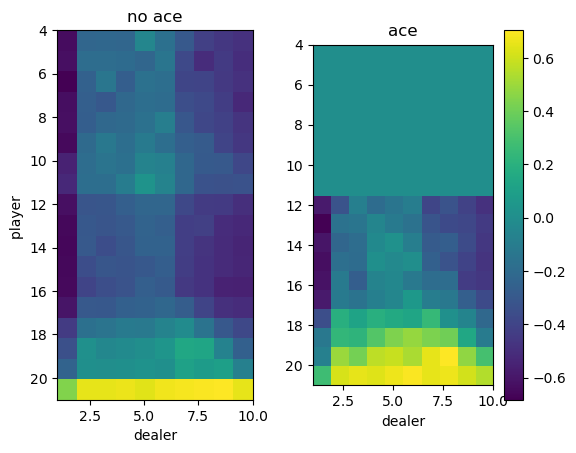

In [12]:
plot_value_function(V)

We see a general trend, as the score of the player increases the value function takes on higher values so our expected return grows. Let see the average result of playing ten thousand games. Let's compare the result, first  using the random policy.


In [13]:
average, std_win = average_wins(environment, episodes=200000)
print("Average number of wins", average)

Average number of wins 0.2827


So the random policy gives us around $28\%$ of wins, now let's see what the trained policy returns:


In [14]:
average, std_win = average_wins(environment, policy, episodes=200000)
print("Average wins:", average, std_win)

Average wins: 0.432225 0.0011077151018538116


Oh wow, more than 10% increase, that's not bad at all, lets see what happens when we use more episodes to train our model. 


In [15]:
policy, V, Q, DELTA = monte_carlo_ES(environment, N_episodes = 500000, discount_factor = 1, first_visit = True, theta = 0)  

Let's see what's happening with the learning rate:


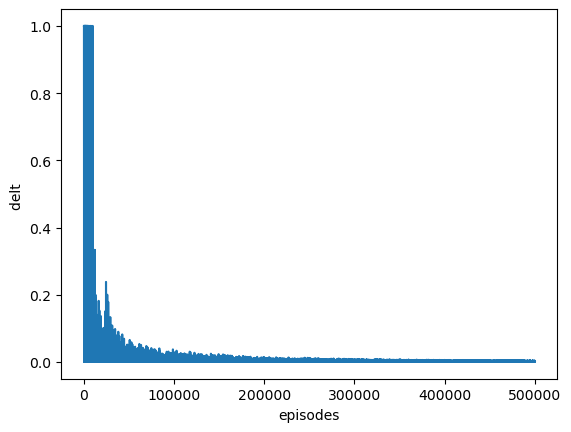

In [16]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

Falling as expected, now let's check what our policy returns:


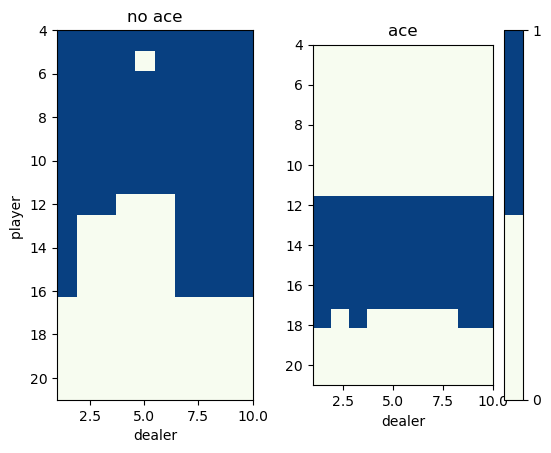

In [17]:
plot_policy_blackjack(policy)

It looks like the optimal policy for blackjack is: If the agent has no ace, the higher the dealer is showing, the more likely the agent is to hit, the exception is if the dealer has an ace. If the agent has an ace, the strategy is different. The agent will stick if the sum of their cards is over 11 and, for the most part, hold the player's sum is over 18. Let's plot the value function to explore the expected returns after 50 000 episodes:


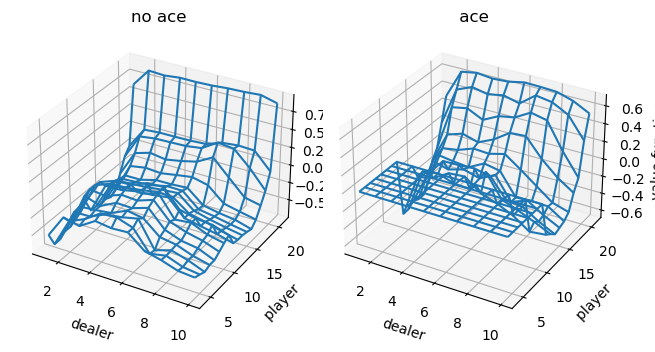

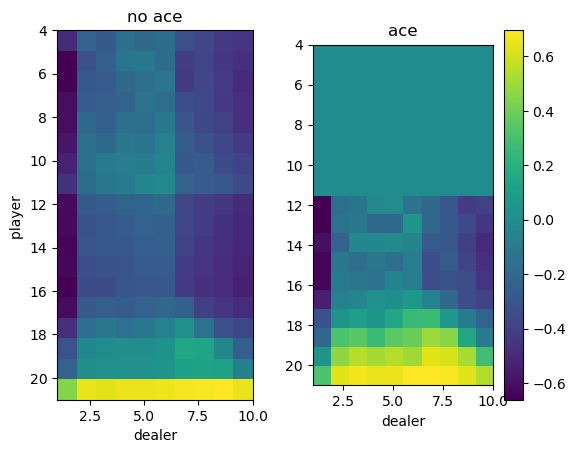

In [18]:
plot_value_function(V)

And, most importantly, lets compare the accuracy of the results:


In [19]:
average, std_win = average_wins(environment, policy, episodes = 500000)
print("Average wins:", average, std_win)

Average wins: 0.43319 0.0007007659008542011


We see as the accuracy is now approximately 43% a 15 % improvement from a random policy:


In [20]:
accuracy = [] 
episodes = []

for n_episode in [1, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]:
    
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA = monte_carlo_ES(environment = environment, 
                                         N_episodes = n_episode, 
                                         discount_factor = 1, 
                                         first_visit = True, 
                                         theta = 0)  
    
    average ,std_win = average_wins(environment = environment, 
                                    policy = policy, 
                                    episodes = 5000000)
    
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

n_episode:  1
n_episode:  1  average:  0.2877968
n_episode:  500
n_episode:  500  average:  0.3769692
n_episode:  1000
n_episode:  1000  average:  0.3919018
n_episode:  5000
n_episode:  5000  average:  0.4128064
n_episode:  10000
n_episode:  10000  average:  0.4199248
n_episode:  50000
n_episode:  50000  average:  0.4299066
n_episode:  100000
n_episode:  100000  average:  0.430742
n_episode:  500000
n_episode:  500000  average:  0.4325338
n_episode:  1000000
n_episode:  1000000  average:  0.4326356


We see that after 50000 episodes the improvement is negligible.


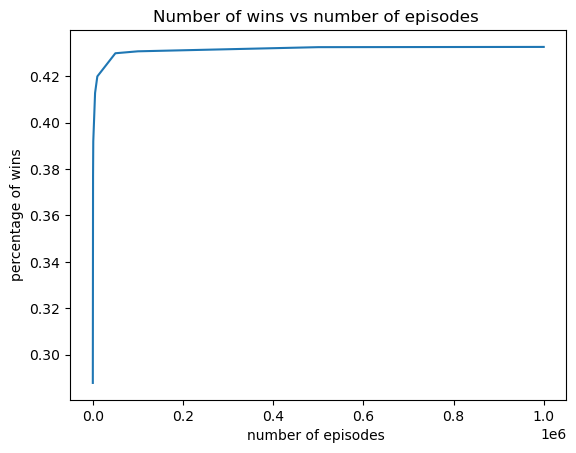

In [21]:
plt.plot(episodes, accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

Let's experiment with the discount factor, to see if it changes anything: 


In [22]:
accuracy=[] 
discounts=[]

for discount in [0, 0.01, 0.1, 0.5, 1.0]:
    
    policy, V, Q, delta = monte_carlo_ES(environment = environment, 
                                         N_episodes = 500000, 
                                         discount_factor = discount, 
                                         first_visit = True, 
                                         theta = 0)  
    
    average ,std_win=average_wins(environment = environment, 
                                  policy = policy, 
                                  episodes = 500000)
    
    print("discount: {}, average wins: {}".format(discount, average))
    discounts.append(discount)
    accuracy.append(average)

discount: 0, average wins: 0.25456
discount: 0.01, average wins: 0.332224
discount: 0.1, average wins: 0.36393
discount: 0.5, average wins: 0.426386
discount: 1.0, average wins: 0.431864


We see as the Discount factor increases, the percentage of wins increases as well, the rate of increase begins to slow down when the discount value is 0.6.


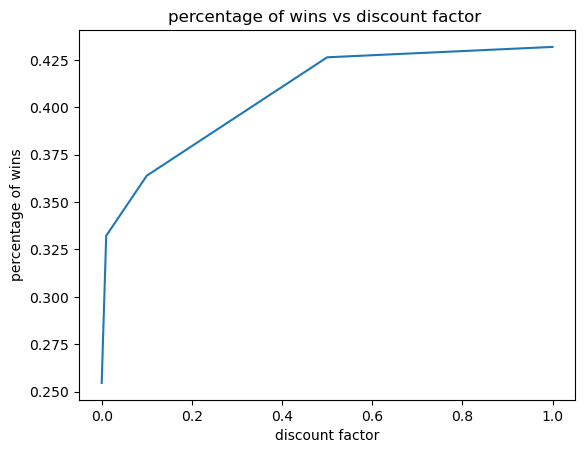

In [23]:
plt.plot(discounts,accuracy)
plt.title("percentage of wins vs discount factor ")
plt.ylabel('percentage of wins')
plt.xlabel('discount factor')
plt.show()

In Conclusion, we have created a successful algorithm, that was able to give us perhaps not a winning, but an optimal strategy for blackjack. 


In [24]:
games_with_policy(environment = environment, 
                  policy = policy, 
                  episodes = 100)

_________________________________________
Episode 0
State: (13, 4, False)
The Agent's current sum: 13, The Dealer's one showing card: 4, Agent's usable ace: False
The Agent has the following cards: [6, 7]
The Dealer has the following cards: [4, 2]
Stand
State: (13, 4, False)
The Agent's current sum: 13, The Dealer's one showing card: 4, Agent's usable ace: False
The Agent has the following cards: [6, 7]
The Dealer has the following cards: [4, 2, 6, 9]
Done: True
state: (13, 4, False)
player has [6, 7]
the players current sum:13,dealer's one showing card:4, usable ace:False
dealer cards: [4, 2, 6, 9] and score: 21 your score i: 13 
agent  loses
_________________________________________
Episode 1
State: (13, 1, False)
The Agent's current sum: 13, The Dealer's one showing card: 1, Agent's usable ace: False
The Agent has the following cards: [10, 3]
The Dealer has the following cards: [1, 10]
Hit
State: (22, 1, False)
The Agent's current sum: 22, The Dealer's one showing card: 1, Agent's u

#### 4.2.3 Monte Carlo On Policy

### 4.3 Q-Learning

In [25]:
unique_states = []
for player_hand in range(1,33):
    for dealer_hand in range(1,12):
        for ace_present in range(0,2):
            identifier = str(player_hand) + '_' + str(dealer_hand) + '_' + str(ace_present)
            unique_states.append(identifier)

q_table = {}
for unique_state in unique_states:
    q_table[unique_state] = {}
    for hit_or_stay in range(0,2):
        q_table[unique_state][hit_or_stay] = 0

print('Total number of possible states of the environment: {}'.format(len(q_table)))

Total number of possible states of the environment: 704


In [26]:
q_table = QLearning(env = environment, 
                    episodes = 500000, 
                    alpha = 0, 
                    gamma = 0.6, 
                    epsilon = 0.1)

Training finished.



In [27]:
games_with_policy_QLearning(environment = environment, 
                            q_table = q_table, 
                            episodes = 100)

_________________________________________
Episode 0
State: (20, 3, False)
The Agent's current sum: 20, The Dealer's one showing card: 3, Agent's usable ace: False
The Agent has the following cards: [10, 10]
The Dealer has the following cards: [3, 10]
Stand
State: (20, 3, False)
The Agent's current sum: 20, The Dealer's one showing card: 3, Agent's usable ace: False
The Agent has the following cards: [10, 10]
The Dealer has the following cards: [3, 10, 2, 10]
Done: True
state: (20, 3, False)
player has [10, 10]
the players current sum:20,dealer's one showing card:3, usable ace:False
dealer cards: [3, 10, 2, 10] and score: 25 your score i: 20 
agent wins
_________________________________________
Episode 1
State: (18, 10, False)
The Agent's current sum: 18, The Dealer's one showing card: 10, Agent's usable ace: False
The Agent has the following cards: [9, 9]
The Dealer has the following cards: [10, 1]
Stand
State: (18, 10, False)
The Agent's current sum: 18, The Dealer's one showing card:

In [28]:
average, std_win = average_wins_QLearning(environment = environment, 
                                          q_table = q_table, 
                                          episodes = 500000)

print("Average wins:", average, std_win)

Average wins: 0.38359 0.00068767537675854


In [3]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

QLearningAgent = BlackjackAgent(environment = environment, 
                                learning_rate = learning_rate, 
                                initial_epsilon = start_epsilon, 
                                epsilon_decay = epsilon_decay, 
                                final_epsilon = final_epsilon)

In [4]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    done = False

    # play one episode
    while not done:
        action = QLearningAgent.get_action(obs)
        next_obs, reward, terminated, truncated = env.step(action)

        # update the agent
        QLearningAgent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    QLearningAgent.decay_epsilon()

100%|██████████| 1000000/1000000 [00:53<00:00, 18556.67it/s]


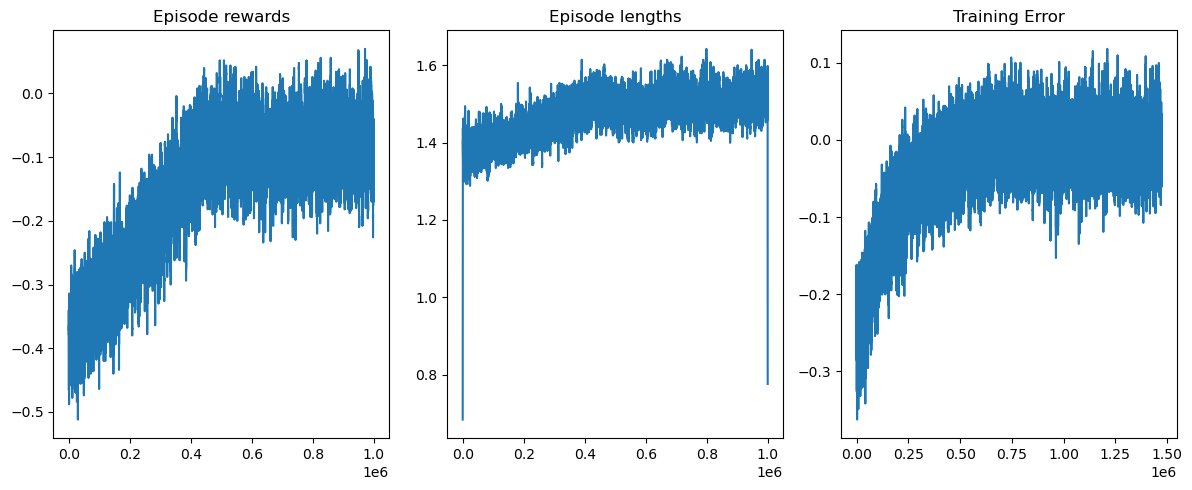

In [5]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(QLearningAgent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

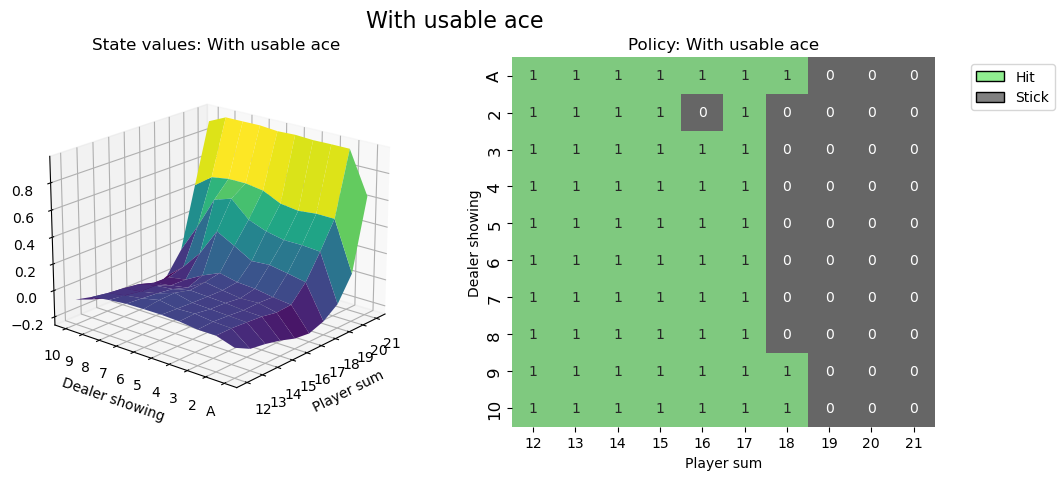

In [6]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

### 4.4 Sarsa (Temporal Difference control)

In [7]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

SarsaAgent = SarsaAgent(environment = environment, 
                            learning_rate = learning_rate, 
                            initial_epsilon = start_epsilon, 
                            epsilon_decay = epsilon_decay, 
                            final_epsilon = final_epsilon)

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    done = False
    rounds = 0
    # play one episode
    while not done:
        if rounds == 0:
            action = SarsaAgent.get_action(obs)
            next_obs, reward, terminated, truncated = env.step(action)
            next_action = QLearningAgent.get_action(next_obs)

            # update the agent
            SarsaAgent.update(obs, action, next_action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

            action = next_action
            obs = next_obs

            rounds += 1

        else:
            next_obs, reward, terminated, truncated = env.step(action)
            next_action = SarsaAgent.get_action(next_obs)

            # update the agent
            SarsaAgent.update(obs, action, next_action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

            action = next_action
            obs = next_obs

    SarsaAgent.decay_epsilon()

100%|██████████| 1000000/1000000 [00:51<00:00, 19277.28it/s]


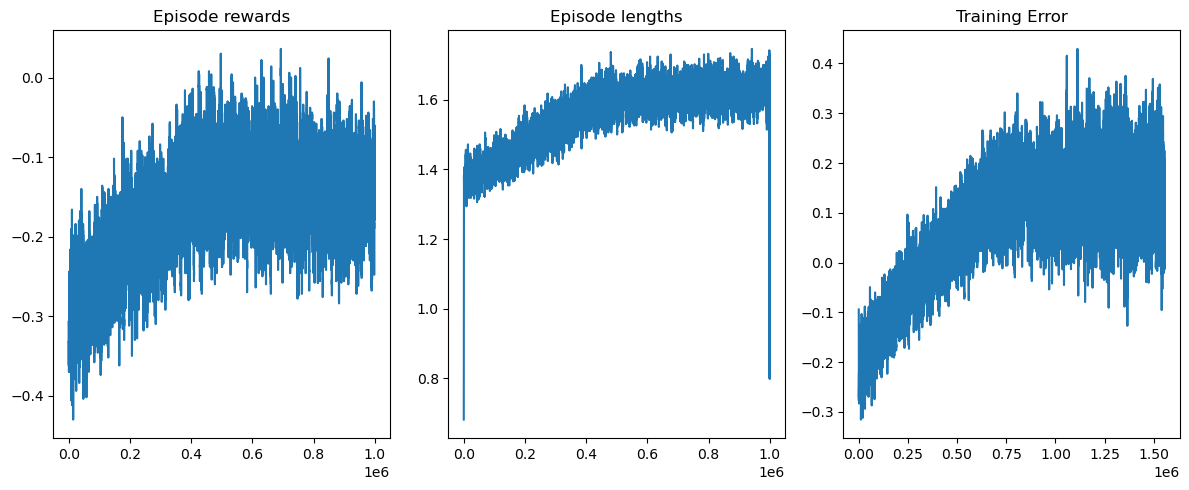

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(SarsaAgent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

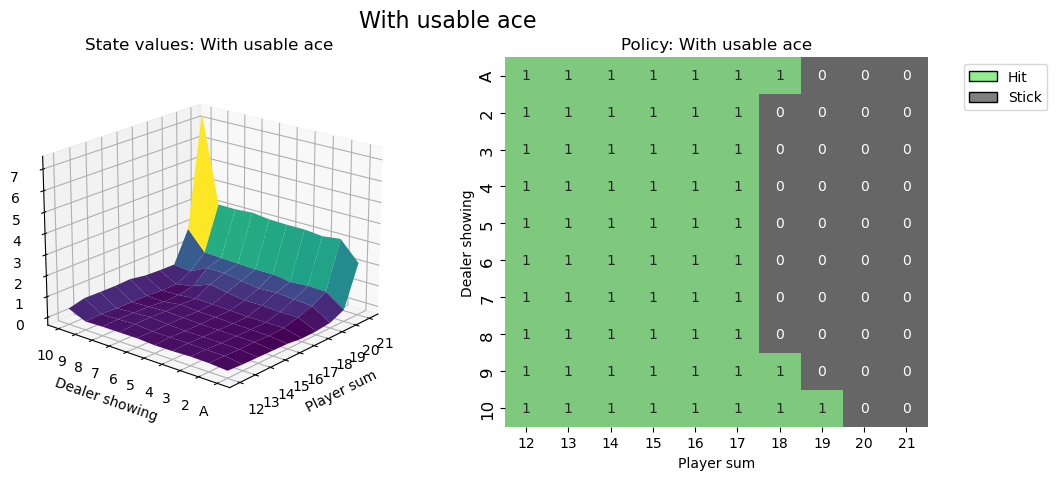

In [10]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()